In [1]:
from pynq import Overlay
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import time 
import tqdm

#### NN module address

In [2]:
IP_CORE_VERSION = 0x00
IP_CORE_ID      = (0x1)<<2
IP_CORE_MAGIC   = (0x2)<<2
IP_CORE_RESET   = (0x3)<<2
IP_CORE_DIN     = (0x4)<<2
IP_CORE_DOUT    = (0x5)<<2
IP_CORE_DBG_CNT = (0x6)<<2
IP_CORE_DBG_MAC0= (0x7)<<2
IP_CORE_DBG_MEM0= (0x8)<<2

### Connect and bring-up NN

In [36]:
q_bits = 14
platform = Overlay(f"KE_nn_q{q_bits}.bit")
# platform?  # What is inside?
neural_net = platform.KE_fc_nn_0

core_ID = neural_net.read(IP_CORE_ID)
core_magic = neural_net.read(IP_CORE_MAGIC)
core_version = neural_net.read(IP_CORE_VERSION)

print(f'CORE ID = {core_ID}')
print(f'CORE MAGIC = {hex(core_magic)}')
print(f'CORE VERSION = {hex(core_version)}')

CORE ID = 0
CORE MAGIC = 0x47465550
CORE VERSION = 0x105


In [37]:
# Simple test 1: read counter

## Reset
neural_net.write(IP_CORE_RESET, 0x1)
sleep(0.01)
neural_net.write(IP_CORE_RESET, 0x0)
sleep(0.01)

for i in range(5):
    cnt_data = neural_net.read(IP_CORE_DBG_CNT)
    print(f'CNT at period #{i} = {hex(cnt_data)}')

    neural_net.write(IP_CORE_DIN, i)

CNT at period #0 = 0x0
CNT at period #1 = 0x1
CNT at period #2 = 0x2
CNT at period #3 = 0x3
CNT at period #4 = 0x4


In [38]:
# Simple test 2: read ROM_0

## Reset
neural_net.write(IP_CORE_RESET, 0x1)
sleep(0.01)
neural_net.write(IP_CORE_RESET, 0x0)
sleep(0.01)

for i in range(5):
    mem0_data = neural_net.read(IP_CORE_DBG_MEM0)
    print(f'ROM_0[{i}] = {hex(mem0_data)}')

    neural_net.write(IP_CORE_DIN, i)

ROM_0[0] = 0xffdee
ROM_0[1] = 0x12f
ROM_0[2] = 0xfff5b
ROM_0[3] = 0xfffb3
ROM_0[4] = 0x164


In [39]:
# Simple test 3: write to DIN sequence 1,2,3...
# Reset
neural_net.write(IP_CORE_RESET, 0x1)
sleep(0.01)
neural_net.write(IP_CORE_RESET, 0x0)
sleep(0.01)

seq = [1, 2, 3, 4]
for i in seq:
    neural_net.write(IP_CORE_DIN, i)
    sleep(0.01)
    mac0_data = neural_net.read(IP_CORE_DBG_MAC0)
    print(f'MAC_0[{i}] = {hex(mac0_data)}')

MAC_0[1] = 0xfffffd
MAC_0[2] = 0xffffff
MAC_0[3] = 0xfffffd
MAC_0[4] = 0xfffffb


In [18]:
# Loading data
images = np.load("normalized_images.npy")
labels = np.load("MNIST_test_labels.npy")

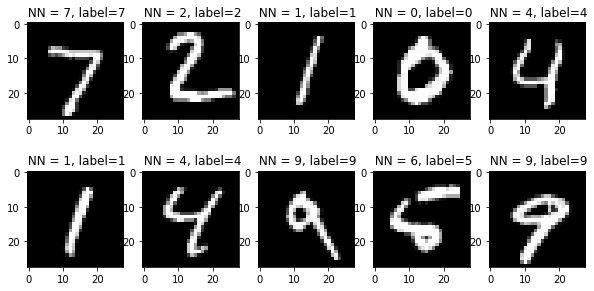

MAC_0 [final] = 0xff67cf
CNT [final] = 784


In [40]:
# Main test: sending test image
fig, ax = plt.subplots(figsize=(10,5), nrows=2, ncols=5)

for n in range(10):
    img_line = images[n,:]
    # reset IP-core
    neural_net.write(IP_CORE_RESET, 0x1)
    sleep(0.001)
    neural_net.write(IP_CORE_RESET, 0x0)
    
    # Send image to NN-IP
    for i in range(len(img_line)):
        pixel_cur = int(img_line[i]*128)
        neural_net.write(IP_CORE_DIN, pixel_cur)
        sleep(0.001)

    nn_out = neural_net.read(IP_CORE_DOUT)
#     print(f'Final result : ', hex(nn_out))
    plt.subplot(2, 5, n + 1)
    plt.imshow(img_line.reshape(28,-1), cmap='gray')
    plt.title(f' NN = {nn_out}, label={labels[n]}')

plt.show()
mac0_data = neural_net.read(IP_CORE_DBG_MAC0)
print(f'MAC_0 [final] = {hex(mac0_data)}')

cnt_data = neural_net.read(IP_CORE_DBG_CNT)
print(f'CNT [final] = {cnt_data}')

### Confusion matrix

In [41]:
# Empty confusion matrix
def create_confusion_matrix(num_classes):
    return np.zeros((num_classes, num_classes), dtype=int)

# Update confusion matrix
def update_confusion_matrix(conf_matrix, true_label, predicted_label):
    conf_matrix[true_label][predicted_label] += 1
    
def predict(neural_net, img_line):
    # reset IP-core
    neural_net.write(IP_CORE_RESET, 0x1)
    sleep(0.0001)
    neural_net.write(IP_CORE_RESET, 0x0)
    
    # Send image to NN-IP
    for i in range(len(img_line)):
        pixel_cur = int(img_line[i]*128)
        neural_net.write(IP_CORE_DIN, pixel_cur)
        sleep(0.0002)

    nn_out = neural_net.read(IP_CORE_DOUT)
    
    return nn_out

In [ ]:
num_classes = 10
conf_matrix = create_confusion_matrix(num_classes)

ts = time.time()
for n in range(images.shape[0]):
    img_line = images[n,:]
    true_label = labels[n]
    label_pred = predict(neural_net, img_line)
    
    update_confusion_matrix(conf_matrix, true_label, label_pred)
    if n%200==0:
        print(f"{n}/{len(labels)} time:{time.ctime()}")
te = time.time()
print(f"Experiment time: {te-ts} sec \n")

print("Confusion matrix:")
print(conf_matrix)
np.save(f"conf_matrix_6q{q_bits}.npy", conf_matrix)

0/10000 time:<built-in function ctime>
200/10000 time:<built-in function ctime>
400/10000 time:<built-in function ctime>
600/10000 time:<built-in function ctime>
800/10000 time:<built-in function ctime>
1000/10000 time:<built-in function ctime>
1200/10000 time:<built-in function ctime>
1400/10000 time:<built-in function ctime>
1600/10000 time:<built-in function ctime>
1800/10000 time:<built-in function ctime>
2000/10000 time:<built-in function ctime>
2200/10000 time:<built-in function ctime>
2400/10000 time:<built-in function ctime>
2600/10000 time:<built-in function ctime>
2800/10000 time:<built-in function ctime>
3000/10000 time:<built-in function ctime>
3200/10000 time:<built-in function ctime>
3400/10000 time:<built-in function ctime>
3600/10000 time:<built-in function ctime>
3800/10000 time:<built-in function ctime>
4000/10000 time:<built-in function ctime>
4200/10000 time:<built-in function ctime>
4400/10000 time:<built-in function ctime>
4600/10000 time:<built-in function ctime>

# Test for all q_bits.

In [ ]:
from pynq import Overlay
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm

# Define the core IP addresses
IP_CORE_VERSION = 0x00
IP_CORE_ID      = (0x1)<<2
IP_CORE_MAGIC   = (0x2)<<2
IP_CORE_RESET   = (0x3)<<2
IP_CORE_DIN     = (0x4)<<2
IP_CORE_DOUT    = (0x5)<<2
IP_CORE_DBG_CNT = (0x6)<<2
IP_CORE_DBG_MAC0= (0x7)<<2
IP_CORE_DBG_MEM0= (0x8)<<2

# Create confusion matrix
def create_confusion_matrix(num_classes):
    return np.zeros((num_classes, num_classes), dtype=int)

# Update confusion matrix
def update_confusion_matrix(conf_matrix, true_label, predicted_label):
    conf_matrix[true_label][predicted_label] += 1
    
# Predict function
def predict(neural_net, img_line):
    # Reset IP-core
    neural_net.write(IP_CORE_RESET, 0x1)
    sleep(0.00005)
    neural_net.write(IP_CORE_RESET, 0x0)
    
    # Send image to NN-IP
    for i in range(len(img_line)):
        pixel_cur = int(img_line[i] * 128)
        neural_net.write(IP_CORE_DIN, pixel_cur)
        sleep(0.00005)

    nn_out = neural_net.read(IP_CORE_DOUT)
    
    return nn_out

def run_experiment(q_bits, images, labels):
    print(f"Processing for bit resolution: {q_bits}")
    
    # Load the overlay
    platform = Overlay(f"KE_nn_q{q_bits}.bit")
    neural_net = platform.KE_fc_nn_0

    # Prepare confusion matrix
    num_classes = 10
    conf_matrix = create_confusion_matrix(num_classes)

    # Process each image
    for n in tqdm(range(10000)):  # Process 10,000 images
        img_line = images[n, :]
        true_label = labels[n]
        label_pred = predict(neural_net, img_line)
        
        update_confusion_matrix(conf_matrix, true_label, label_pred)

#         if n % 200 == 0:
#             print(f"Processed {n}/{len(labels)} for bit resolution {q_bits}")

    return conf_matrix

# Loading data
images = np.load("normalized_images.npy")
labels = np.load("MNIST_test_labels.npy")

bit_resolutions = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1] 
results = {}

# Run experiments 
for q_bits in bit_resolutions:
    print(f'Q = {q_bits}')
    conf_matrix = run_experiment(q_bits, images, labels)
    print(f'Confusion matrix for bit resolution {q_bits}:')
    print(conf_matrix)
    np.save(f"conf_matrix_6q{q_bits}.npy", conf_matrix)



Q = 10
Processing for bit resolution: 10


100%|██████████| 10000/10000 [35:01<00:00,  4.76it/s]


Confusion matrix for bit resolution 10:
[[ 964    0    2    2    0    2    8    1    1    0]
 [   0 1110    4    4    0    1    4    2   10    0]
 [  14    3  919   10   15    4   12   13   34    8]
 [   2    0   21  924    1   22    3    9   18   10]
 [   2    3    3    1  925    0   11    2    4   31]
 [  10    3    4   34   12  766   16   11   29    7]
 [  11    3    4    2    8   12  915    1    2    0]
 [   3    6   26    4    8    0    0  956    4   21]
 [   4    5    5   18    9   20   11   16  885    1]
 [  12    5    3   12   28   12    0   18   12  907]]
Q = 9
Processing for bit resolution: 9


100%|██████████| 10000/10000 [34:59<00:00,  4.76it/s]


Confusion matrix for bit resolution 9:
[[ 964    0    2    2    0    2    8    1    1    0]
 [   0 1110    4    4    0    1    4    2   10    0]
 [  14    3  919   10   15    4   12   13   34    8]
 [   2    0   21  924    1   22    3    9   18   10]
 [   2    3    3    1  925    0   11    2    4   31]
 [  10    3    4   34   12  766   16   11   29    7]
 [  11    3    4    2    8   12  915    1    2    0]
 [   3    7   25    5    8    0    0  957    3   20]
 [   5    5    5   17    9   20   11   16  885    1]
 [  12    5    3   12   28   12    0   17   12  908]]
Q = 8
Processing for bit resolution: 8


100%|██████████| 10000/10000 [34:51<00:00,  4.78it/s]


Confusion matrix for bit resolution 8:
[[ 964    0    2    2    0    2    8    1    1    0]
 [   0 1110    4    4    0    1    4    2   10    0]
 [  14    3  921   10   15    3   12   13   33    8]
 [   2    0   25  922    1   22    3    9   17    9]
 [   2    3    5    0  921    0   11    2    4   34]
 [  10    3    5   34   12  765   15   11   30    7]
 [  11    3    6    2    8   12  913    1    2    0]
 [   3    6   26    4    8    0    0  955    4   22]
 [   5    5    5   17    9   20   11   16  884    2]
 [  12    5    3   12   26   12    0   16   11  912]]
Q = 7
Processing for bit resolution: 7


100%|██████████| 10000/10000 [34:52<00:00,  4.78it/s]


Confusion matrix for bit resolution 7:
[[ 964    0    2    3    0    2    7    1    1    0]
 [   0 1110    4    4    0    1    4    2   10    0]
 [  14    3  920   10   15    4   12   13   33    8]
 [   2    0   22  925    1   21    3    9   16   11]
 [   2    3    3    1  923    0   11    2    3   34]
 [  10    3    5   39   12  761   15   10   29    8]
 [  12    3    4    2    8   11  915    1    2    0]
 [   3    7   25    6    8    0    0  952    3   24]
 [   5    5    5   19    9   21   11   16  881    2]
 [  12    6    3   12   25   11    0   14    9  917]]
Q = 6
Processing for bit resolution: 6


100%|██████████| 10000/10000 [34:57<00:00,  4.77it/s]


Confusion matrix for bit resolution 6:
[[ 964    0    2    3    0    2    7    1    1    0]
 [   0 1109    4    4    0    2    4    2   10    0]
 [  14    3  920   10   15    4   12   13   33    8]
 [   2    0   22  923    1   21    3    9   19   10]
 [   2    3    5    1  923    0    9    2    4   33]
 [  10    3    4   36   13  763   16   11   28    8]
 [  11    3    4    2    8   14  914    1    1    0]
 [   3    7   25    6    8    1    0  954    3   21]
 [   4    5    5   18   10   23   11   13  882    3]
 [  12    5    2   12   26   13    0   16   10  913]]
Q = 5
Processing for bit resolution: 5


 62%|██████▏   | 6228/10000 [22:02<13:06,  4.80it/s]